# MNIST
### multinomial classification부터 다른 통계적 기법을 활용하여 정확도를 올리자!
* MNIST는 이미지를 학습하고 prediction하는 예제 28 * 28 크기의 이미지가 주어진다
* 한 사람이 0 ~ 9 까지 쓴 숫자가 각각의 이미지에 쓰여 있고, 이러한 데이터가 5만개 이상있다.
* 각 숫자를 분류하고 학습하여 사진을 찍었을 때 의미하는 숫자가 무엇인지 예측해보자.


### 1. Tensorflow에서 제공하는 예제를 통해 먼저 공부하자(더 쉬움)

#### 1 ) 필요한 module import

In [1]:
# 필요한 module import
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

# Data Loading
# 우선 데이터 폴더 밑에 mnist 폴더를 만들어주자 ( 압축파일 네개가 생성될 예정 )
# 속성으로 먼저 one_hot encoding을 하면 y값이 encoding된 채로 나온다
# tensorflow예제에서만 가능하고 kaggle에선 직접해야한다 !
mnist = input_data.read_data_sets("./DA/mnist", one_hot = True)


C:\Users\student\Anaconda3\envs\cpu_env\lib\site-packages\tensorflow\python\framework\dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\student\Anaconda3\envs\cpu_env\lib\site-packages\tensorflow\python\framework\dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\student\Anaconda3\envs\cpu_env\lib\site-packages\tensorflow\python\framework\dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\student\Anaconda3\envs\cpu_env\lib\site-packages\ten

Extracting ./DA/mnist\train-images-idx3-ubyte.gz
Extracting ./DA/mnist\train-labels-idx1-ubyte.gz
Extracting ./DA/mnist\t10k-images-idx3-ubyte.gz
Extracting ./DA/mnist\t10k-labels-idx1-ubyte.gz


#### 2 ) 데이터 로딩 [ 시간 오래 걸림 주의! ]

In [2]:
# 위의 데이터를 파일로 만들어주자
train_x_data_df = pd.DataFrame(mnist.train.images)
train_x_data_df.to_csv("./mnist_x_data.csv", index=False)
# x data의 각 pixel(각 column)은 0과 1 사이의 값으로, scaling된 숫자는 진하기를 나타낸다.
# 이미지는 RGB + 알파로 표현되는 삼차원이다 
# 현재는 0과 1사이의 숫자이고 0과 가까울수록 흰색을 지칭, 1과 가까울수록 색상이 어두워진다(검은색).

train_y_data_df = pd.DataFrame(mnist.train.labels)
train_y_data_df.to_csv("./mnist_y_data.csv", index=False)

#### 3 ) tensorflow로 machine learning

In [3]:
# placeholder
X = tf.placeholder(shape = [None, 784], dtype = tf.float32)
Y = tf.placeholder(shape = [None, 10], dtype = tf.float32)
# Weight, bias
W = tf.Variable(tf.random_normal([784, 10]), name = "Weight")
b = tf.Variable(tf.random_normal([10]), name = "bias")
# Hypothesis
logit = tf.matmul(X,W) + b
H = tf.nn.softmax(logit)
# Cost
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logit,
                                                                labels = Y))
# Train
train = tf.train.GradientDescentOptimizer(learning_rate = 0.5).minimize(cost)
# Session
sess = tf.Session()
sess.run(tf.global_variables_initializer())    

In [4]:
# 학습
# 데이터가 매우 크기 때문에 이제 로딩할 때 많이하지말자
# train data를 한 번 학습하는 것 = 1epoch
train_epoch = 30
for step in range(train_epoch):
    _, cost_val = sess.run([train,cost],
                           feed_dict = { X : mnist.train.images,
                                        Y : mnist.train.labels})
    if step % 3 == 0:
        print("Cost 값은 : {}". format(cost_val))
# numpy array로 처리하기 위해 df이 아닌 mnist.train.images를 그대로 사용하자

Cost 값은 : 19.766536712646484
Cost 값은 : 11.08687973022461
Cost 값은 : 8.81389331817627
Cost 값은 : 7.11265754699707
Cost 값은 : 5.837159633636475
Cost 값은 : 4.900848865509033
Cost 값은 : 4.216954708099365
Cost 값은 : 3.7111566066741943
Cost 값은 : 3.3278369903564453
Cost 값은 : 3.028888463973999


#### 4 ) accuracy 측정

In [5]:
predict = tf.argmax(H,1)
correct = tf.equal(predict, tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct, dtype = tf.float32))
print("정확도는 : {}".format(sess.run(accuracy,
                                  feed_dict = {X : mnist.test.images,
                                               Y : mnist.test.labels})))

정확도는 : 0.5236999988555908


 #### 5 ) 반복과 배치를 통해 모델 다시 만들기

In [6]:
# 너무 많은 데이터가 있으면 데이터를 못불러들이거나 데이터를 잘못 계산한다
# 따라서 한번에 다 부르지 말고 특정 사이즈만큼만 불러서 학습한다
# 반복과 배치를 통해 데이터를 나누어 학습시켜보자
# 아래의 모델은 위와 동일하지만 line 21의 batch size부터 살펴보자

In [7]:
# placeholder
X = tf.placeholder(shape = [None, 784], dtype = tf.float32)
Y = tf.placeholder(shape = [None, 10], dtype = tf.float32)
# Weight, bias
W = tf.Variable(tf.random_normal([784, 10]), name = "Weight")
b = tf.Variable(tf.random_normal([10]), name = "bias")
# Hypothesis
logit = tf.matmul(X,W) + b
H = tf.nn.softmax(logit)
# Cost
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logit,
                                                                labels = Y))
# Train
train = tf.train.GradientDescentOptimizer(learning_rate = 0.5).minimize(cost)
# Session
sess = tf.Session()
sess.run(tf.global_variables_initializer())    

train_epoch = 30
# 55000개를 100개씩 잘라서 학습시켜보자
batch_size = 100

for step in range(train_epoch):
    num_of_iter = int(mnist.train.num_examples / batch_size)
    cost_val = 0
    
    for i in range(num_of_iter):
        # 학습용 데이터에서 100개씩 반복해서 뜯어온다 ( 그 다음 백개 ! )
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        _, cost_val = sess.run([train,cost],
                               feed_dict = { X : batch_x,
                                             Y : batch_y})
    if step % 3 == 0:
        print("Cost 값은 : {}". format(cost_val))

predict = tf.argmax(H,1)
correct = tf.equal(predict, tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct, dtype = tf.float32))
print("정확도는 : {}".format(sess.run(accuracy,
                                  feed_dict = {X : mnist.test.images,
                                               Y : mnist.test.labels})))

Cost 값은 : 0.8596975207328796
Cost 값은 : 0.6384946703910828
Cost 값은 : 0.38845375180244446
Cost 값은 : 0.31539544463157654
Cost 값은 : 0.5171910524368286
Cost 값은 : 0.46512994170188904
Cost 값은 : 0.27266165614128113
Cost 값은 : 0.3753893971443176
Cost 값은 : 0.28353968262672424
Cost 값은 : 0.1510837972164154
정확도는 : 0.9192000031471252


#### 6 ) Prediction

In [8]:
# 랜덤으로 하나의 데이터를 추출해서 이를 이용해서 prediction한 후, 결과를 비교해보자
r = np.random.randint(0, mnist.test.num_examples)
# 난수가 의미하는 행의 label 값을 먼저 구해보자
# 이차원으로 해주기 위해 [ r : r+1 ] 대입
print("Label : {}".format(sess.run(tf.argmax(mnist.test.labels[r:r+1], axis=1))))
print("predict : {}".format(sess.run(tf.argmax(H,1),
                                     feed_dict = { X : mnist.test.images[r:r+1] })))
# 90%의 정확도이기 때문에 틀린 값이 나올 수 있다 ~ 


Label : [1]
predict : [1]


#### 7 ) 그림을 그려보자

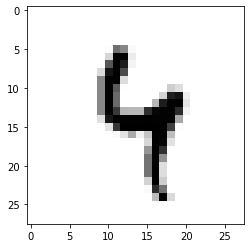

In [9]:

# 랜덤수 생성
r = np.random.randint(0, mnist.test.num_examples)

## 1차원 배열을 다시 28 * 28 의 2차원 배열로 바꿔보자
#mnist.test.images[r:r+1].reshape(28,28)

## 그림을 그려보자 1
#plt.imshow(mnist.test.images[r:r+1].reshape(28,28))

## 그림을 그려보자 2
plt.imshow(mnist.test.images[r:r+1].reshape(28,28), cmap="Greys")

### 2. kaggle에서 제공하는 데이터로 예측해보자!

#### 1 ) 필요한 module import

In [10]:
# 필요한 module import
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

# Data Loading
# 우선 데이터 폴더 밑에 mnist 폴더를 만들어주자 ( 압축파일 네개가 생성될 예정 )
# 속성으로 먼저 one_hot encoding을 하면 y값이 encoding된 채로 나온다
# tensorflow예제에서만 가능하고 kaggle에선 직접해야한다 !
mnist_df = pd.read_csv("C:/python_DA/Ex/DA/train.csv")

#### 2 ) 데이터 로딩 [ 시간 오래 걸림 주의! ]

In [11]:
mnist_df.shape
x_df = pd.DataFrame(mnist_df.drop(columns = ["label"]))
x_df.to_csv("./x_df.csv", index=False)
y_df = pd.DataFrame(mnist_df["label"].values)
y_df.to_csv("./y_df.csv", index=False)

#### 3 ) 데이터 전처리

In [12]:
# 데이터 결측치 확인
x_df.isnull().sum(axis=1).sum(axis=0)
y_df.isnull().sum(axis=1).sum(axis=0)

# 데이터 확인 
#display(y_df.head())
#display(x_df.head())

# 데이터 train, test로 나누자
split_num = int(x_df.shape[0] * 0.8)  # 42000, 33600, 8400

# x_df scaling
scaler = MinMaxScaler()
x_data = scaler.fit_transform(x_df)

train_x_data = x_data[:split_num]
train_x_data.shape # 33600, 784
test2_x_data = x_data[split_num:]
test2_x_data.shape # 8400, 784

# y_df one hot encoding
sess = tf.Session()
train_y_data = sess.run(tf.one_hot(y_df.loc[:split_num-1,0], 10))
train_y_data.shape # 33600, 10
test_y_data = sess.run(tf.one_hot(y_df.loc[split_num:,0],10))
test_y_data.shape # 8400, 10

(8400, 10)

#### 4 ) machine learning

In [17]:
X = tf.placeholder(shape = [None, 784], dtype = tf.float32)
Y = tf.placeholder(shape = [None, 10], dtype = tf.float32)
W = tf.Variable(tf.random_normal([784, 10]), name = "Weight")
b = tf.Variable(tf.random_normal([10]), name = "bias")
logit = tf.matmul(X,W) + b
H = tf.nn.softmax(logit)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logit,
                                                                labels = Y))
train = tf.train.GradientDescentOptimizer(learning_rate = 0.5).minimize(cost)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_epoch = 30
batch_size = 100
for step in range(train_epoch):
    num_of_iter = int(len(train_x_data) / batch_size)
    cost_val = 0
    
    for i in range(num_of_iter):
        # 학습용 데이터에서 100개씩 반복해서 뜯어온다 ( 그 다음 백개 ! )
        batch_x = train_x_data[batch_size * i : batch_size * ( i + 1 )]
        batch_y = train_y_data[batch_size * i : batch_size * ( i + 1 )]
        _, cost_val = sess.run([train,cost],
                               feed_dict = { X : batch_x,
                                             Y : batch_y})
    if step % 3 == 0:
        print("Cost 값은 : {}". format(cost_val))

predict = tf.argmax(H,1)
correct = tf.equal(predict, tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct, dtype = tf.float32))
print("정확도는 : {}".format(sess.run(accuracy,
                                  feed_dict = {X : test2_x_data,
                                               Y : test_y_data})))

print("predict : {}".format(sess.run(tf.argmax(H,1),
                                     feed_dict = { X : test2_x_data })))


Cost 값은 : 1.3148949146270752
Cost 값은 : 0.847979724407196
Cost 값은 : 0.7234461903572083
Cost 값은 : 0.6582573056221008
Cost 값은 : 0.6179904937744141
Cost 값은 : 0.5912045836448669
Cost 값은 : 0.5716921091079712
Cost 값은 : 0.5561500787734985
Cost 값은 : 0.5430468916893005
Cost 값은 : 0.5316665172576904
정확도는 : 0.9060714244842529
predict : [0 7 7 ... 7 6 9]


#### 5 ) 제출할 test data를 입력하여 결과를 보자 !

In [19]:
test_df = pd.read_csv("C:/python_DA/Ex/DA/test.csv")
scaler = MinMaxScaler()
x_data = scaler.fit_transform(x_df)
test_x_data = scaler.transform(test_df)

X = tf.placeholder(shape = [None, 784], dtype = tf.float32)
Y = tf.placeholder(shape = [None, 10], dtype = tf.float32)
W = tf.Variable(tf.random_normal([784, 10]), name = "Weight")
b = tf.Variable(tf.random_normal([10]), name = "bias")
logit = tf.matmul(X,W) + b
H = tf.nn.softmax(logit)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logit,
                                                                labels = Y))
train = tf.train.GradientDescentOptimizer(learning_rate = 0.5).minimize(cost)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_epoch = 30
batch_size = 100
for step in range(train_epoch):
    num_of_iter = int(len(x_df) / batch_size)
    cost_val = 0
    
    for i in range(num_of_iter):
        # 학습용 데이터에서 100개씩 반복해서 뜯어온다 ( 그 다음 백개 ! )
        batch_x = train_x_data[100*i:100*(i+1)]
        batch_y = train_y_data[100*i:100*(i+1)]
        _, cost_val = sess.run([train,cost],
                               feed_dict = { X : batch_x,
                                             Y : batch_y})
    if step % 3 == 0:
        print("Cost 값은 : {}". format(cost_val))

predict = tf.argmax(H,1)
correct = tf.equal(predict, tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct, dtype = tf.float32))
print("정확도는 : {}".format(sess.run(accuracy,
                                  feed_dict = {X : test2_x_data,
                                               Y : test_y_data})))


print("predict : [{}]".format(sess.run(tf.argmax(H,1),
                                     feed_dict = { X : test_x_data })))

result = sess.run(tf.argmax(H,1),
                                     feed_dict = { X : test_x_data })
result_df = pd.DataFrame({'Label' : result })
result_df.index = np.arange(1,len(result_df)+1)


result_df.to_csv("result.csv", index = True, index_label = "ImageId")



Cost 값은 : nan
Cost 값은 : nan
Cost 값은 : nan
Cost 값은 : nan
Cost 값은 : nan
Cost 값은 : nan
Cost 값은 : nan
Cost 값은 : nan
Cost 값은 : nan
Cost 값은 : nan
정확도는 : 0.9110714197158813
predict : [[2 0 5 ... 3 9 2]]


#### 7 ) 직접 이미지를 찍어보자

Cost 값은 : 1.2201826572418213
Cost 값은 : 0.830609142780304
Cost 값은 : 0.7419776320457458
Cost 값은 : 0.690538227558136
Cost 값은 : 0.6525172591209412
Cost 값은 : 0.6229352355003357
Cost 값은 : 0.5996458530426025
Cost 값은 : 0.5809520483016968
Cost 값은 : 0.5656080842018127
Cost 값은 : 0.5527008771896362
정확도는 : 0.9072619080543518
predict : [[5]]


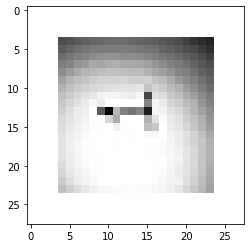

In [44]:
########### 어디선가 가져온 코딩 #################
from PIL import Image, ImageFilter

def imageprepare(argv):
    im = Image.open(argv).convert('L')
    width = float(im.size[0])
    height = float(im.size[1])
    newImage = Image.new('L', (28, 28), (255))  # 우리가 테스트할 네트워크는 28/28 이미지이다
    # 입력된 28/28이 아닌 이미지를 28/28로 변환하기 위해 가로 세로 중 어느쪽이 큰지 확인
    if width > height:
        # 폭이 더 큰 경우 처리 로직
        nheight = int(round((20.0 / width * height), 0))  # resize height according to ratio width
        # 20/20 이미지로 변환하고
        img = im.resize((20, nheight), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wtop = int(round(((28 - nheight) / 2), 0))  #
        newImage.paste(img, (4, wtop))  # 리사이즈된 이미지를 흰색 바탕의 캔버스에 붙여 넣는다
    else:
        # 높이가 더 큰경우에 처리 로직
        nwidth = int(round((20.0 / height * width), 0))
        if (nwidth == 0):
            nwidth = 1
            # resize and sharpen
        img = im.resize((nwidth, 20), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wleft = int(round(((28 - nwidth) / 2), 0))
        newImage.paste(img, (wleft, 4))
    # newImage.save("sample.png")
    tv = list(newImage.getdata())  # 픽셀 데이터로 변환
    # 255의 RGB 0 흰색, 1 검은색의 이진수로 노멀라이제이션 작업을 수행
    tva = [(255 - x) * 1.0 / 255.0 for x in tv]
    return tva

##################################################################################################################
npa = np.asarray(imageprepare("C:/python_DA/Ex/DA/1.jpg"), dtype=np.float32)

scaler = MinMaxScaler()
pic_df = [npa]

x_data = scaler.fit_transform(x_df)
test_x_data = scaler.transform(pic_df)

X = tf.placeholder(shape = [None, 784], dtype = tf.float32)
Y = tf.placeholder(shape = [None, 10], dtype = tf.float32)
W = tf.Variable(tf.random_normal([784, 10]), name = "Weight")
b = tf.Variable(tf.random_normal([10]), name = "bias")
logit = tf.matmul(X,W) + b
H = tf.nn.softmax(logit)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logit,
                                                                labels = Y))
train = tf.train.GradientDescentOptimizer(learning_rate = 0.5).minimize(cost)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_epoch = 30
batch_size = 100

for step in range(train_epoch):
    num_of_iter = int(len(train_x_data) / batch_size)
    cost_val = 0
    for i in range(num_of_iter):
        # 학습용 데이터에서 100개씩 반복해서 뜯어온다 ( 그 다음 백개 ! )
        batch_x = train_x_data[batch_size*i:batch_size*(i+1)]
        batch_y = train_y_data[batch_size*i:batch_size*(i+1)]
        _, cost_val = sess.run([train,cost],
                               feed_dict = { X : batch_x,
                                             Y : batch_y})
    if step % 3 == 0:
        print("Cost 값은 : {}". format(cost_val))

predict = tf.argmax(H,1)
correct = tf.equal(predict, tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct, dtype = tf.float32))
print("정확도는 : {}".format(sess.run(accuracy,
                                  feed_dict = {X : test2_x_data,
                                               Y : test_y_data})))


print("predict : [{}]".format(sess.run(tf.argmax(H,1),
                                     feed_dict = { X : test_x_data })))


plt.imshow(npa.reshape(28,28), cmap="Greys")
